In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import random
import scipy
import glob
import os
from sklearn.metrics import root_mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [4]:
CIs = []
def convert_ci(ci):
    if type(ci) == str:
        ci_list = [float(i) for i in ci.split('_')]
        return ci_list
    else:
        ci_str = str(ci[0]) + '_' + str(ci[1]) + '_' + str(ci[2]) + '_' + str(ci[3])
        return ci_str
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../data/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = {}

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']

    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        print(file)
        df = df[schema]  # Reorder columns to match the schema
        ci = df.iloc[0,:4].to_numpy()
        print(ci)
        data_frames[convert_ci(ci)] = df
        CIs.append(convert_ci(ci))
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]

    return data_frames,csv_files 
data_frames,file_list = import_dfs()
print(data_frames.keys())
print(data_frames[CIs[0]].columns)
print(file_list)
print(CIs)

../data\25.45nh60ab20.csv
[20.  0. 60.  0.]
../data\25.46nh30ab30.csv
[30.  0. 30.  0.]
../data\25.47nh5ab80.csv
[80.  0.  5.  0.]
../data\5.100nh40ab80.csv
[80.  0. 40.  0.]
../data\5.102nh20ab40.csv
[40.5         0.         21.75        3.37262013]
../data\5.103nh40ab30.csv
[30.4   0.   43.    2.55]
../data\5.106nh100ab40.csv
[4.00389864e+01 6.40149834e-02 1.00045181e+02 1.42108547e+00]
../data\5.107nh55ab55.csv
[55.        0.       55.        0.623377]
../data\5.109nh5ab55.csv
[55.  0.  5.  0.]
../data\5.110nh10ab55.csv
[55.  0. 10.  0.]
../data\5.112nh78ab35.csv
[32.5  0.  78.   2.5]
../data\5.48nh20ab80.csv
[80.  0. 20.  0.]
../data\5.80nh12ab40.csv
[38.75  0.   12.    1.4 ]
../data\5.81nh5ab30.csv
[30.  0.  5.  0.]
../data\nh60ab80.csv
[80.  0. 60.  0.]
dict_keys(['20.0_0.0_60.0_0.0', '30.0_0.0_30.0_0.0', '80.0_0.0_5.0_0.0', '80.0_0.0_40.0_0.0', '40.5_0.0_21.75_3.372620126926563', '30.4_0.0_43.0_2.55', '40.038986354775815_0.0640149834167829_100.04518072289156_1.4210854715202004',

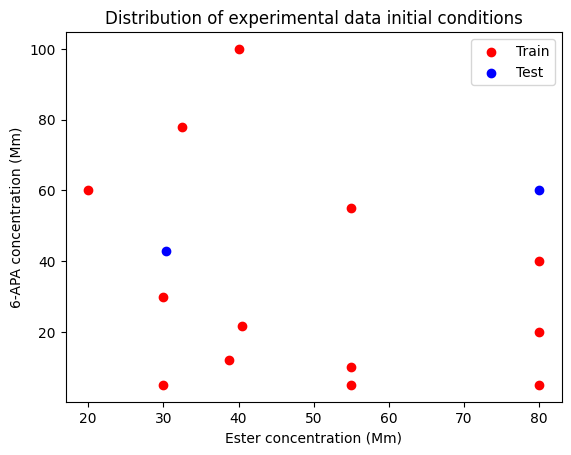

In [5]:
train_size = len(CIs)-2
test_size = len(CIs) - train_size
ic2trainplot = np.zeros((train_size,2))
ic2testplot = np.zeros((test_size,2))
train_ci, test_ci = train_test_split(CIs,train_size=.9,random_state=21)


#for i in range(len(CIs)):
#    ic2plot[i,:] = [convert_ci(CIs[i])[0],convert_ci(CIs[i])[2]]

for idx,i in enumerate(train_ci):
    ic2trainplot[idx,:] = [convert_ci(i)[0],convert_ci(i)[2]]
for idx,i in enumerate(test_ci):
    ic2testplot[idx,:] = [convert_ci(i)[0],convert_ci(i)[2]]

plt.title("Distribution of experimental data initial conditions")
plt.xlabel("Ester concentration (Mm)")
plt.ylabel("6-APA concentration (Mm)")
plt.scatter(ic2trainplot[:,0],ic2trainplot[:,1],c='r');
plt.scatter(ic2testplot[:,0],ic2testplot[:,1],c='b');
plt.legend(['Train','Test']);


In [6]:
Cez = 1

k2 = 187 
k3 = 44
k4 = 235
k5 = 9.0
KS = 0.38 * 1000
KP = 0.095 * 1000
KN = 0.043 * 1000
kmenos4 = 217
P = np.zeros(8)
P[0]   = k2 
P[1]   = k3    
P[2]   = k4      
P[3]   = k5      
P[4]   = KS     
P[5]   = KP      
P[6]   = KN      
P[7]   = kmenos4

Np = len(P)

labels = ['k2',
'k3',
'k4',
'k5',
'KS',
'KP',
'KN',
'kmenos4']


In [7]:
def enzymic_amox(t,y, 
k2,
k3,
k4,
k5,
KS,
KP,
KN,
kmenos4,
):
    Cez = 1
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    RP = (Cez)/(k3 * KN + k4 * CNH + k5 * CNH) * (((k2 * k4 * CAB * CNH)/ (KS)) - ((kmenos4 * CAN * (k3 * KN + k5 * CNH))/KP))
    RB = (Cez * (k3 * KN + k5 * CNH) / (k3 * KN + k4 * CNH + k5 * CNH)) * (((k2 * CAB)/KS) - ((kmenos4 * CAN) / KP))
    RS = -(RP + RB)
    RNu = -(RP)

    dy = np.zeros(4)

    dy[0] =  RS       
    dy[1] =  RP
    dy[2] =  -(RP)  
    dy[3] = RB      
    
    return np.array(dy)   

In [8]:
# ode15s from MATLAB

def ode15s_amox(P, CI, t):
    return scipy.integrate.solve_ivp(enzymic_amox,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='BDF',args=P).y.T

In [9]:
# RK45 solver

def ode15s_amox(P, CI, t):
    try:
        sol = scipy.integrate.solve_ivp(
            enzymic_amox, 
            t_span=(t[0], t[-1]), 
            t_eval=t, 
            y0=CI, 
            method='BDF', 
            args=P, 
            #atol=1e-8, 
            #tol=1e-6
        )
        if sol.status != 0:
            raise ValueError("ODE solver failed to converge")
        return sol.y.T
    except Exception as e:
        print(f"Solver failed with error: {e}")
        # Handle solver failure (e.g., return NaNs or retry with different parameters)
        return np.full((len(CI), len(t)), np.nan).T
    

In [10]:
def mcmc(P,N=5000,ode_solver=ode15s_amox,status=False,results_folder='temp'):

    Np = len(P)
    
    # Extracting data

    exps = []
    all_times = []
    times = []
    
    for i in range(len(CIs)):
        all_times.append(data_frames[CIs[i]].loc[:,'apa_t'].dropna().to_numpy())

    size_train = len(train_ci)
    train_ci_list = [convert_ci(ci) for ci in train_ci]

    for i in range(size_train):
        t = data_frames[train_ci[i]].loc[:,'apa_t'].dropna().to_numpy()

        exp = np.zeros((len(t),4))
        
        exp[:,0]  = data_frames[train_ci[i]].loc[:,'ester_mm'].dropna().to_numpy()
        exp[:,1]  = data_frames[train_ci[i]].loc[:,'amox_mm'].dropna().to_numpy()
        exp[:,2] =  data_frames[train_ci[i]].loc[:,'apa_mm'].dropna().to_numpy()
        exp[:,3]  = data_frames[train_ci[i]].loc[:,'aoh_mm'].dropna().to_numpy()
        exps.append(exp)

        times.append(t)

    Cez = 1

    refs = []
    desvio = np.zeros((4,size_train))

    for i in range(size_train):
        t = times[i]
        ref = np.zeros((len(t),4))
        Y = ode_solver(P,convert_ci(CIs[i]),t)

        ref[:,0]   =  Y[:,0]      
        ref[:,1]   =  Y[:,1]    
        ref[:,2]   =  Y[:,2]      
        ref[:,3]  =   Y[:,3]

        refs.append(ref)

        desvio[0,i] =  0.1*max(ref[:,0]) 
        desvio[1,i] =  0.1*max(ref[:,1])
        desvio[2,i] =  0.1*max(ref[:,2])
        desvio[3,i] =  0.1*max(ref[:,3])
    
    waux      = 6e-3 
    media_g   = 1       #Média gaussiana
    desviop_g = 0.6     #Desvio dos parâmetros ao utilizar priori gaussian

    estimate = [i for i in range(len(P))]
    Nfix = len(estimate)

    p_ref = P                   
    p_old = P                     

    media_MCMC = media_g*P
    desvio_P   = desviop_g*P

    w = np.ones((1,Np))   
    w = w*waux  

    parametro_exato = (p_ref*np.ones((N,1))).T
    
    aceitacao    = np.zeros((1,N))  
    cadeia       = np.zeros((Np,N)) 
    conv_likeli  = np.zeros((1,N))
    k=0
    lk_old = 0
        
    for i in range(size_train):
        Lk_1 = np.dot((exps[i][:,0] - refs[i][:,0]),(exps[i][:,0] - refs[i][:,0]).T) / (desvio[0,i]**2)     
        Lk_2 = np.dot((exps[i][:,1] - refs[i][:,1]),(exps[i][:,1] - refs[i][:,1]).T) / (desvio[1,i]**2)      
        Lk_3 = np.dot((exps[i][:,2] - refs[i][:,2]),(exps[i][:,2] - refs[i][:,2]).T) / (desvio[2,i]**2)       
        Lk_4 = np.dot((exps[i][:,3] - refs[i][:,3]),(exps[i][:,3] - refs[i][:,3]).T) / (desvio[3,i]**2)  
        lk_partial = Lk_1 + Lk_2 + Lk_3 + Lk_4
        lk_old += lk_partial
    

    prior_old = np.sum((((p_old - media_MCMC))/((desvio_P)**2)))
    cadeia[:,0] = p_old
    
    # Contador para verificar a aceitação
    for i in range(0, N):
        progress = (i / N) * 100
        if status:
            print(progress,end='\r')
        # New parameter vector
        P_new = p_old + w * np.random.randn(Np) * p_old
        #print('p_new: ', P_new)
        # Simulate using ODE solver

        chain_ref = []
        for j in range(size_train):
            t = times[j]
            ref = np.zeros((len(t),4))

            Y = ode_solver(P_new[0],convert_ci(CIs[j]),t)
            ref[:,0]  =  Y[:,0]      
            ref[:,1]  =  Y[:,1]    
            ref[:,2]  =  Y[:,2]      
            ref[:,3] =   Y[:,3]
            chain_ref.append(ref)


        # Calculate new prior
        Prior_new = np.sum(((P_new[0] - media_MCMC) / desvio_P) ** 2)

        Lk_new = 0
        # Likelihood calculations
        for j in range(size_train):
            Lk_1 = np.dot((exps[j][:,0] - chain_ref[j][:,0]),(exps[j][:,0] - chain_ref[j][:,0]).T) / (desvio[0,j]**2)     
            Lk_2 = np.dot((exps[j][:,1] - chain_ref[j][:,1]),(exps[j][:,1] - chain_ref[j][:,1]).T) / (desvio[1,j]**2)      
            Lk_3 = np.dot((exps[j][:,2] - chain_ref[j][:,2]),(exps[j][:,2] - chain_ref[j][:,2]).T) / (desvio[2,j]**2)       
            Lk_4 = np.dot((exps[j][:,3] - chain_ref[j][:,3]),(exps[j][:,3] - chain_ref[j][:,3]).T) / (desvio[3,j]**2)  
            lk_partial = Lk_1 + Lk_2 + Lk_3 + Lk_4
            Lk_new += lk_partial 
    
        # MCMC acceptance check
        if np.log(random.random()) < (-0.5 * (Lk_new + Prior_new - lk_old - prior_old)):
            p_old = P_new
            lk_old = Lk_new
            prior_old = Prior_new
            k += 1
            print(k)
        
        # Store results
        aceitacao[0,i] = k
        cadeia[:, i] = p_old
        conv_likeli[0,i] = lk_old + prior_old
    print("aceitacao: ", k/N, 'k: ', k)
    fig,ax = plt.subplots(2,4,figsize=[20,8])
    ax = ax.flatten()

    labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']
    
    for idx,g in enumerate(ax):
        g.plot(cadeia[idx,:])    
        g.set_title(labels[idx])
        g.set_ylabel("Value")
        g.set_xlabel("Iteration")
    
    fig.savefig(f"../results/{results_folder}/chains/multi_{N}.png",dpi=400)
    plt.close()    

    aq = int(0.9 * N)  # Starting index for the burn-in period
    IC = 0.99          # Confidence interval level

    # Confidence interval bounds
    xaux = (1 - IC) / 2
    IC_inf = xaux
    IC_sup = 1 - xaux
    estimate = [i for i in range(Np)]

    amostra = N - aq + 1
    amostras = [] # [CIs, Nics, t, subs]


    output_par = np.zeros((amostra,Np))
    for i in range(len(CIs)):
        t = all_times[i]
        inst_amostra = np.zeros((len(list(range(aq, N + 1))),len(t),4))

        for idx,j in enumerate(range(aq, N + 1)):
            ii = j - aq
            paux = cadeia[:, j - 1]
            output_par[ii,:] = paux
            
            Y = ode_solver(paux,convert_ci(CIs[i]),t)
            inst_amostra[idx,:,0]  = Y[:,0]
            inst_amostra[idx,:,1] = Y[:,1]
            inst_amostra[idx,:,2] = Y[:,2]
            inst_amostra[idx,:,3] = Y[:,3]
        
        amostras.append(inst_amostra)


    AB_media = []
    AN_media = []
    NH_media = []
    AOH_media =[]
    AB_sup = []
    AN_sup = []
    NH_sup = []
    AOH_sup =[]
    AB_inf = []
    AN_inf = []
    NH_inf = []
    AOH_inf =  []   

    for i in range(len(CIs)):
        t = all_times[i]
        amostra = amostras[i]
        
        AB_mean = np.zeros(len(t))
        AB_inferior = np.zeros(len(t))
        AB_superior = np.zeros(len(t))
        NH_mean = np.zeros(len(t))
        NH_inferior = np.zeros(len(t))
        NH_superior = np.zeros(len(t))

        for j in range(len(t)):    
            AB_mean[j] = np.mean(amostra[:,j,0])
            y = np.percentile(amostra[:, j,0], [IC_inf * 100, IC_sup * 100])
            AB_inferior[j] = y[0]
            AB_superior[j] = y[1]

            NH_mean[j] = np.mean(amostra[:, j,2])
            y = np.percentile(amostra[:, j,2], [IC_inf * 100, IC_sup * 100])
            NH_inferior[j] = y[0]
            NH_superior[j] = y[1]
        
        AN_mean = np.zeros(len(t))
        AN_inferior = np.zeros(len(t))
        AN_superior = np.zeros(len(t))
        AOH_mean = np.zeros(len(t))
        AOH_inferior = np.zeros(len(t))
        AOH_superior = np.zeros(len(t))
        
        for j in range(len(t)):
            AN_mean[j] = np.mean(amostra[:, j, 1])
            y = np.percentile(amostra[:, j,1], [IC_inf * 100, IC_sup * 100])
            AN_inferior[j] = y[0]
            AN_superior[j] = y[1]

            AOH_mean[j] = np.mean(amostra[:, j,3])
            y = np.percentile(amostra[:, j,3], [IC_inf * 100, IC_sup * 100])
            AOH_inferior[j] = y[0]
            AOH_superior[j] = y[1]

        AB_media.append(AB_mean)
        NH_media.append(NH_mean)
        AB_inf.append(AB_inferior)
        AB_sup.append(AB_superior)
        NH_inf.append(NH_inferior)
        NH_sup.append(NH_superior)
        AN_media.append(AN_mean)
        AOH_media.append(AOH_mean)
        AN_inf.append(AN_inferior)
        AN_sup.append(AN_superior)
        AOH_inf.append(AOH_inferior)
        AOH_sup.append(AOH_superior)

    # individual plot
    # Ensure 'results' directory exists
    results_dir = f'../results/{results_folder}'

    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    for i in range(len(CIs)):
        names = ['POH-PGME','Amoxicillin','6-APA','POHPG']
        t = all_times[i]
        style = ['or','og','ob','ok']
        mstyle = ['-r','-g','-b','-k']
        medidas = [
            [AB_media[i], AB_inf[i], AB_sup[i]],
            [AN_media[i], AN_inf[i], AN_sup[i]],
            [NH_media[i], NH_inf[i], NH_sup[i]],
            [AOH_media[i],AOH_inf[i],AOH_sup[i]]
        ]
        fig,ax = plt.subplots(2,2,figsize=(10,10))
        for idx,axis in enumerate(ax.flatten()):
            sname = names[idx]
            medida = medidas[idx]
            
            axis.plot(t, data_frames[CIs[i]].iloc[:,idx].to_numpy(), style[idx], label=sname)
            axis.plot(t, medida[0], mstyle[idx])
            axis.plot(t, medida[1], '--r',linewidth=0.5)
            axis.plot(t, medida[2], '--r',linewidth=0.5) 
            axis.set_xlabel('Tempo (min)')
            axis.set_ylabel(f'Concentração de {sname} (mm)')  # Use f-string for proper string formatting
            axis.legend()  # Adjust legend position

        fig.savefig(os.path.join(results_dir, f"{N}_{file_list[i]}_mcmc.png"), dpi=300)
        plt.close()  # Close the figure to release memory
    return output_par,k/N

In [11]:
output_par, aceitacao = mcmc(P=P,N=10000,status=True,results_folder='model_donald')

C:\Users\artur\AppData\Local\Temp\ipykernel_16820\3667378347.py:80: RuntimeWarning: divide by zero encountered in scalar divide
  Lk_4 = np.dot((exps[i][:,3] - refs[i][:,3]),(exps[i][:,3] - refs[i][:,3]).T) / (desvio[3,i]**2)


C:\Users\artur\AppData\Local\Temp\ipykernel_16820\3667378347.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  Lk_4 = np.dot((exps[j][:,3] - chain_ref[j][:,3]),(exps[j][:,3] - chain_ref[j][:,3]).T) / (desvio[3,j]**2)
C:\Users\artur\AppData\Local\Temp\ipykernel_16820\3667378347.py:125: RuntimeWarning: invalid value encountered in scalar subtract
  if np.log(random.random()) < (-0.5 * (Lk_new + Prior_new - lk_old - prior_old)):


c:\Users\artur\Desktop\lneoc\pibic_lneoc\deep_learning\venv\Lib\site-packages\scipy\integrate\_ivp\bdf.py:416: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


aceitacao:  0.0 k:  0


In [12]:
P_conf = pd.DataFrame(output_par)
P_mean = P_conf.describe().iloc[1,:].to_numpy()
print(P_mean)
P_new = P_mean
P_error = P_conf.describe().iloc[2,:].to_numpy() / np.sqrt(P_conf.size)

for i in range(len(labels)):
    print(f'{labels[i]}: {P_mean[i]} +- {P_error[i]}')

[187.  44. 235.   9. 380.  95.  43. 217.]
k2: 187.0 +- 0.0
k3: 44.0 +- 0.0
k4: 235.0 +- 0.0
k5: 9.0 +- 0.0
KS: 380.0 +- 0.0
KP: 95.0 +- 0.0
KN: 43.0 +- 0.0
kmenos4: 217.0 +- 0.0


In [13]:
def model_eval(x_model, t_model, val_x, val_t):
    fig, axis = plt.subplots(2, 2, figsize=[6, 6])
    labels = ['POH-PGME','Amoxicillin','6-APA','POHPG']
    mlabels = ['POH-PGME model','Amoxicillin model','6-APA model','POHPG model']
    style = ['.r','.g','.b','.k']
    mstyle = ['-k','-k','-k','-k']    
    for idx,ax in enumerate(axis.flatten()):
        ax.plot(val_t, val_x[:, idx], style[idx], label=labels[idx],linewidth=0.5,markersize=5)
        ax.plot(t_model, x_model[:, idx], mstyle[idx], label=mlabels[idx],linewidth=0.9,markersize=3)
        ax.set_title(f'{labels[idx]}')
        ax.set_ylim([val_x[:, idx].min()-5, val_x[:, idx].max()+5])
        ax.set_xlim([0, val_t[-1]+5])
        ax.legend()

In [14]:
def mass_deviation(model_output, experimental_data):
    
    exp_mass = np.sum(model_output, axis=1)    
    model_mass = np.sum(experimental_data, axis=1)

    mass_deviation = np.sum(np.abs(exp_mass - model_mass))
    return mass_deviation


Eval all new parameter set

Error [20.  0. 60.  0.]: 162.57969171522748	mass: 5946.791998609324	r2: -50.642343519989986
Error [30.  0. 30.  0.]: 59.10349773478635	mass: 2147.0460287038927	r2: -53.92812131726307
Error [80.  0.  5.  0.]: 35.12091111426165	mass: 1010.3653054814469	r2: -1.0747375693847112
Error [80.  0. 40.  0.]: 65.68249204277136	mass: 3318.898039867425	r2: -26.2673916177067
Error [40.5         0.         21.75        3.37262013]: 29.80191861947582	mass: 1308.0736082205385	r2: -9.323477118683428
Error [30.4   0.   43.    2.55]: 98.15083563682862	mass: 4213.19731119549	r2: -51.9501245709691
Error [4.00389864e+01 6.40149834e-02 1.00045181e+02 1.42108547e+00]: 217.8067574663876	mass: 8729.450349791656	r2: -49.40000930061439
Error [55.        0.       55.        0.623377]: 89.75209974956641	mass: 2471.6058950415168	r2: -16.596825986775556
Error [55.  0.  5.  0.]: 26.64138929428608	mass: 609.6819572085813	r2: -1.4151149089852153
Error [55.  0. 10.  0.]: 21.1037404533478	mass:

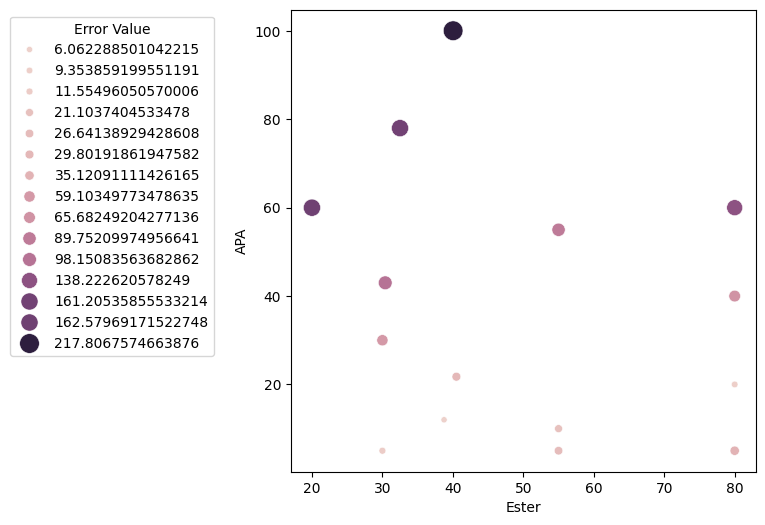

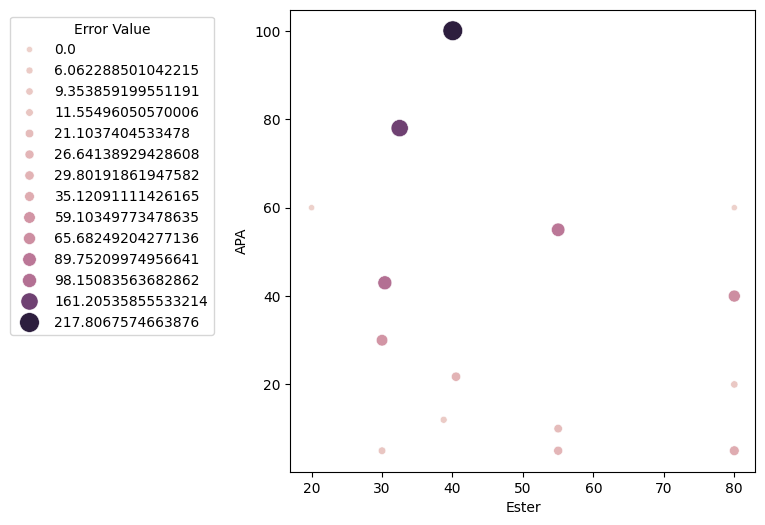

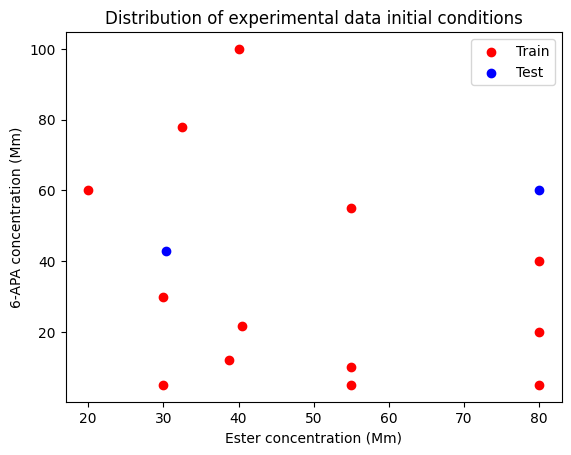

In [15]:
def eval_all(P_new,less_bad=False):
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']

    total_error = 0
    if less_bad:
        surface_error = np.zeros((len(data_frames),3)) # columns = mse error, ester init, apa init 
    else:
        surface_error = np.zeros((len(data_frames),3)) # columns = mse error, ester init, apa init 
    
    total_mass_error = 0
    for idx,df in enumerate(data_frames):
        x_target = data_frames[df].loc[:,x_names].to_numpy()
        t_target = data_frames[df]['apa_t'].to_numpy()
    
        ic = x_target[0]
        

        surface_error[idx,1] = ic[0] # ester
        surface_error[idx,2] = ic[2] # apa
        

        if ((ic[0] == 20 and ic[2] == 60) or (ic[0] == 80 and ic[2] == 60)) and (less_bad):
            surface_error[idx,0] = 0
            continue

        t_model = np.linspace(t_target[0],t_target[-1],40)
        
        sol = ode15s_amox(P_new,ic,t_model)
        sol_val = ode15s_amox(P_new,ic,t_target).T

        error = root_mean_squared_error(x_target.T, sol_val)
        mass_error = mass_deviation(sol_val,x_target.T)
        r2 = r2_score(x_target.T,sol_val)

        surface_error[idx,0] = error

        total_error += error
        total_mass_error += mass_error
        
        print(f'Error {ic}: {error}\tmass: {mass_error}\tr2: {r2}')

        x_model = sol.T
        #model_eval(x_model.T,t_model,x_target,t_target)
        
    surfacedf = pd.DataFrame(surface_error,columns=['RMSE','Ester','APA'])
    
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=surfacedf, x='Ester', y='APA', size='RMSE', hue='RMSE', sizes=(20, 200),legend='full')
    plt.legend(title='Error Value', loc='upper right', bbox_to_anchor=(-0.15, 1))
    #sns.heatmap(surfacedf,annot=True,fmt=".3f")
    print(f'Total error: {total_error/len(data_frames)}\tmass error:{total_mass_error/len(data_frames)}')
print("\nEval all new parameter set\n")
eval_all(P)
print("\nEval all new parameter set\n")
eval_all(P_new,less_bad=True)

plt.figure()
plt.title("Distribution of experimental data initial conditions")
plt.xlabel("Ester concentration (Mm)")
plt.ylabel("6-APA concentration (Mm)")
plt.scatter(ic2trainplot[:,0],ic2trainplot[:,1],c='r');
plt.scatter(ic2testplot[:,0],ic2testplot[:,1],c='b');
plt.legend(['Train','Test']);